# Welcome to GRC ML Hackathon Challenge A!

This challenge is a collaborative effort to perform data science using a collection of publications.  During this challenge, we will focus on pin-fin heat exchangers. The approach used is nearly identical to an anlysis which involving the NASA Taxonomy and USAF SBIR. That notebook for that analysis has been graciously shared with us by Charles Liles (charles.a.liles@nasa.gov), and can be read here: https://visualization.larc.nasa.gov/dash/notebooks/SBIR_LDA.

The data used for Challenge A is open source, and it was graciously provided by Karsten Look (karsten.look@nasa.gov).

This notebook performs the same latent Dirichlet allocation (LDA) topic modeling on the heat exchanger dataset as in the previously posted example. Some participants will will leverage inexpensive Google Cloud Storage for hosting the data, while others may use Google CoLab (via Google Drive) or storage available on a local computer such as a laptop. If using Google Cloud Storage, you can skip directly to this section by clicking this link: <a href='#cloud_storage'>Cloud Storage Read/Write Demo'</a>. If using Google CoLab, you can skip directly to section... #TODO include section on reading data from Google CoLab. And running the notebook locally, you can reference #TODO include section for reading data locally.

We will also perform t-SNE on vectorized heat exchanger data and interactive visualization using the Python bokeh library.  This link: <a href='#tsne_bokeh'>t-SNE and bokeh Visualization'</a> can be clicked to skip directly to this section of the notebook.

## Import Software Dependencies and Define Functions

We will next import all Python libraries needed for model generation below.  We will also build a function to handle entity extraction from text, stopword removal, and snowball stemming.  Stop words are common word such as "a" and "the" which are not useful for NLP machine learning; you can read more about stop word removal here: https://en.wikipedia.org/wiki/Stop_words. Stemming is a means of transforming words to their root form. For example, the terms "radiate", "radiates", and "radiation" would all transform to a root form of "radiat" after stemming.  More information about Snowball stemming is available here: https://en.wikipedia.org/wiki/Snowball_(programming_language).

In [18]:
# Filter deprecation warning
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Uncomment the below lines if these dependencies are not already installed
#!pip install --upgrade scispacy
#!pip install --upgrade spacy
#!pip install --upgrade gensim
#!pip install --upgrade pyLDAvis

# Uncomment the below line if en_core_sci_sm is not loaded on your system.
# !pip install --upgrade https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz

#uncomment if you need to read the data files from google cloud storage
from google.cloud import storage

#uncomment if you need to read data in from Google Drive that's mounted to a CoLab notebook
#from google.colab import drive

import time
import re
import bokeh
from sklearn.manifold import TSNE
import pandas as pd
import scispacy
import spacy
import string
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
from gensim import similarities
from sklearn.neighbors import NearestNeighbors
from nltk.corpus import stopwords  
from nltk.stem.snowball import SnowballStemmer
from scipy.spatial.distance import jensenshannon
import numpy as np
from google.cloud import storage

import en_core_sci_sm
nlp = en_core_sci_sm.load()
#nlp = spacy.load('en_core_sci_sm')

import nltk
# Uncomment the below line if nltk's stopwords are not already on your system.
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer('english')

from bokeh.models import HoverTool, CustomJS, ColumnDataSource
from bokeh.palettes import viridis, Viridis256, magma, Turbo256, linear_palette
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

/opt/conda/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/opt/conda/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/opt/conda/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/opt/conda/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from co

Loading BokehJS ...

`get_entitites` has been modified do some additional cleaning of terms. Several regular expressions have been added to remove additional special characters and whitespace.

In [20]:
def get_entities(temp_article):
    '''
    A function for preprocessing an article's text.  Spacy's en_core_sci_sm library is used to identify scientfic domain terms. 
    Stopword removal and snowball stemming is then used to cleanup each of term.
    Arg:
        temp_article: the string input for preprocessing
    Returns:
        temp_entities: a list of preprocessed terms
    '''
    if len(temp_article) > nlp.max_length:
        nlp.max_length = len(temp_article)
    doc = nlp(temp_article)
    temp_entities = []
    for n in doc.ents:
        temp_str = ''
        for w in n:
            if w not in stop_words:
               
                str_w = str(w)
                if str_w.isalpha():
                    str_w = str_w.lower()
                    str_w = re.sub('\[.*?\]', '', str_w)
                    str_w = re.sub('https?://\S+|www\.\S+', '', str_w)
                    str_w = re.sub('<.*?>+', '', str_w)
                    str_w = re.sub('[%s]' % re.escape(string.punctuation), '', str_w)
                    str_w = re.sub('\n', '', str_w)
                    str_w = re.sub('\w*\d\w*', '', str_w)
                    str_w = re.sub(r"\s+"," ", str_w)
                    temp_str += stemmer.stem(str_w) + ' '
                else:
                    temp_str += str_w + ' '
                    
        temp_entities.append(temp_str.strip())
    return temp_entities

We will now move forward with our preprocessing and LDA visualizations.  If you are already familiar with this work from the previous notebook, you can skip to t-SNE/visualization by following this link: <a href='#tsne_bokeh'>t-SNE and bokeh Visualization'</a>.

The team has already cleaned up the PDF articles, with the formatted version saved to `Combined_Output.txt`. Artciles in the file are newline delimited.

# Reading the data
For this challenge, there are threee different ways you can read the data.
1. From GCP Cloud storage
2. From Google Drive
3. From your local harddrive.

## From GCP Cloud storage
To read from GCP Cloud storage, we'll use the bucket ID variable and `google.cloud.storage` to connect to the bucket, and download the file a a string. The method name `download_as_string` is a little misleading. What's returned is a bytes object, so we need to decode it using `decode("utf-8")` to convert it to a Python string. All the articles are contained within a single string, so to go to a list of articles we use `split("\n")` to split the string using newline characters as the delimiter.

To preview the data, we only show the first 500 characters for the first few articles. Be careful when printing the downloaded bytes object, string, and list within JupyterLab and on Google Cloud. Trying to print everything might result in warnings, errors, or the notebook locking up.

In [21]:
import xml.etree.ElementTree as ET

In [22]:
def is_xml(blob, fp):
    start = blob.name.startswith(fp)
    end = blob.name.endswith(".xml")
    return (start and end)

In [23]:
def noun_is_valid(noun):
    
    no_hyph_noun = noun.replace("-","")
    only_hyphs_or_alpha = no_hyph_noun.isalpha()
    
    is_not_capitalized = noun[0].islower()
    
    if only_hyphs_or_alpha and is_not_capitalized:
        return True
    else: 
        return False

In [24]:
def get_file_metadata(fname):
    xpath = "./Metadata/Fields"
    out_metadata = {}
    
    fp = f"challenge-ab/processed/{fname}"
    blob = bucket.get_blob(fp)
    data = blob.download_as_string().decode("utf-8")
    root = ET.fromstring(data)
    
    for item in root.findall(xpath):
        for meta_item in item.getchildren():
            out_metadata.update({meta_item.tag: meta_item.text})
    
    return out_metadata
        

In [25]:
def get_noun_string(fname):
    
    xpath = "./Metadata/Facets/Facet/_word/noun/general"
    out_nouns = []
    
    fp = f"challenge-ab/processed/{fname}"
    blob = bucket.get_blob(fp)
    data = blob.download_as_string().decode("utf-8")
    root = ET.fromstring(data)
    
    for item in root.findall(xpath):
        if noun_is_valid(item.text):
            out_nouns.append(item.text)
    
    return (" ").join(out_nouns)


In [26]:
def get_ordered_metadata(requested_field, metadata_dict):
    """
    "date": "1212110011000",
    "title": "doi:10.1016/j.ijheatmasstransfer.2007.11.028",
    "directory": "/data/wex_collection_data/KARSTEN_NLP_PDF/source",
    "filename": "paper 100_1-s2.0-S0017931007006990-main.pdf",
    "xml_filename": "0110.xml"
    "extension": ".pdf",
    "modifieddate": "1599581133567",
    "filesize": "1126925",
    "source": "unixfs",
    "language": "en",
    "doctype": "application/pdf",
    "crwsp": "t1599581168252",
    "crwid": "KARSTEN_NLP_PDF.UNIX_19538",
    "code": "200",
    """
    
    # Init output array of empty strings
    out_array = [""] * len(metadata_dict)
    
    # Iterate through metadata dict items
    for file_index, file_metadata in metadata_dict.items():
        out_array[file_index] = file_metadata.get(requested_field)
    
    return out_array
    
    

In [27]:
def get_xml_noun_data(bucket_id="grc-ml-hackathon"):
    """
    Input:
      bucket_id: string -> The identifier for your Google Cloud Storage bucket
    Ouput:
      A tuple with the format (metadata_dict, noun_strings)
        
        metadata_dict: Dictionary{String: Int} -> Each value in the dict will be the name of an XML data file 
                                                  from the Google Cloud Bucket. The mapped value for each filename
                                                  will be an integer that represents the index of that particular 
                                                  filename's data in the noun_strings array

        noun_strings: List[String]             -> Each list item is a string of nouns separated by a single space. 
                                                  Each "noun string" corresponds to one of the initial XML data files in the
                                                  Google Cloud Bucket.
        example:
             metadata_dict = {'0110.xml': 0, '0111.xml': 1, '0112.xml': 2}
             noun_strings
    """

    # Construct client to initialize the bucket interface
    client = storage.Client()
    bucket = client.get_bucket(bucket_id)
    
    # Init output data structures
    noun_strings = []
    metadata_dict = {}

    # Iterate through files in bucket, looking for .xml files
    for ind, blob in enumerate(bucket.list_blobs()):

        if is_xml(blob, fp="challenge-ab/processed/"):

            fname = blob.name.lstrip("challenge-ab/processed/")

            noun_string = get_noun_string(fname)
            noun_strings.append(noun_string)
            file_index = noun_strings.index(noun_string)
            
            file_metadata = get_file_metadata(fname)
            file_metadata.update({"xml_filename": fname})
            
            metadata_dict.update({file_index: file_metadata})
    
    return metadata_dict, noun_strings


In [28]:
# Data direct from PDF
BUCKET_ID="grc-ml-hackathon"
client = storage.Client()
bucket = client.get_bucket(BUCKET_ID)
blob = bucket.get_blob("challenge-ab/processed/Combined_Output.txt")
data1 = blob.download_as_string().decode("utf-8")
data1 = data1.split("\n")

# Data from XML
metadata_dict, data = get_xml_noun_data(BUCKET_ID)

print("\n\n".join((data[0][:500], data[1][:500], data[2][:500])))

journal heat mass transfer analysis heat conduction problem fin temperature heat transfer part characteristic plate pin fin engineering institute street form abstract solution state heat conduction problem fin cross-section dependance fin parameter base conductance geo fin parameter ratio fin tip base temperature excess plate fin pin fin tip tip heat transfer coefficient power function fin excess temperature value exponent range curve fin parameter exponent curve fin addition fin tip parameter c

heat transfer flow structure characterization pin fin spray manufacturing international journal heat mass transfer content list journal heat mass transfer journal homepage com heat transfer flow structure characterization pin fin spray manufacturing right author university engineering article history form focus work characterization performance pin fin array spray manufacturing process heat transfer pressure loss round base base diamond base pin fin array configuration fin density performance 

## Fit Heat Exchanger Articleswith a Bag of Words Vectorizer

We will set up a bag of words vectorizer below.  This is a means of representing an article or document via the number of word occurences within it.  We will then fit this vectorizer to our heat exchanger data. Before creating the bag of words, we print the first 5000 characters of the first article, to help visually inspect the text. We also create a word cloud to visually look at word frequency within the corpus.

In [29]:
print(data[0][:5000])

journal heat mass transfer analysis heat conduction problem fin temperature heat transfer part characteristic plate pin fin engineering institute street form abstract solution state heat conduction problem fin cross-section dependance fin parameter base conductance geo fin parameter ratio fin tip base temperature excess plate fin pin fin tip tip heat transfer coefficient power function fin excess temperature value exponent range curve fin parameter exponent curve fin addition fin tip parameter curve maximum point point curve inflection point fin inflection point parameter fin function parameter fin product parameter fin correction factor form formula result study form relation table plot design fin right keyword single fin tip temperature optimization procedure explicit form formula introduction author book extend surface heat transfer type surface design analysis type optimization fin fin spine finding profile shape heat flow mal conductance term study mass fin optimization problem mi

In [30]:
# !pip install --upgrade Wordcloud 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

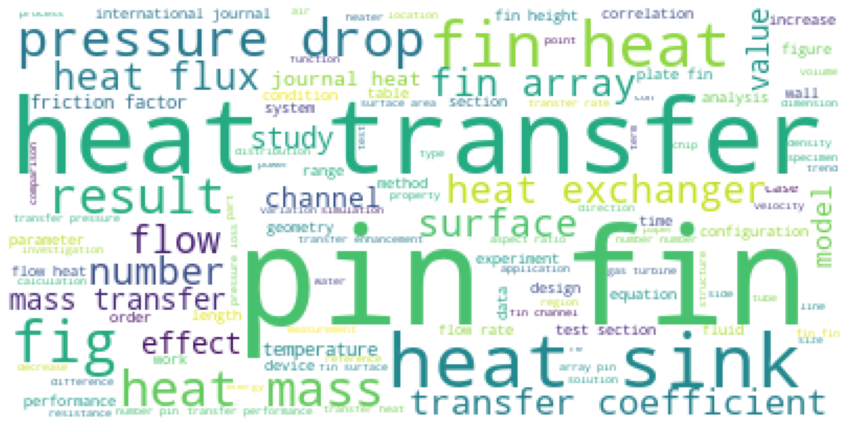

In [31]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, contour_color='steelblue').generate(' '.join(data))
plt.figure( figsize=(15,15) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Next, we create a bag of words using scikit-learns CountVectorizer. `tokenizer`, `min_df`, and `max_df` are all parameters to reduce the size of our bag of words. `get_entities` is a method designed to significant data cleaning, including stemming, removal of stop words, and removing unwanted characters from text like special characters. `min_df` and `max_df` limit words based off the minimum and maximum number of documents they appear in.

In [32]:
bow_vector = CountVectorizer(tokenizer=get_entities, min_df=2, max_df=5, ngram_range=(1,3))
data_vectorized = bow_vector.fit_transform(data)

## Define the LDA Model and Fit to the Vectorized Data

We can now define our LDA model and fit it to our vectorized heat exchanger data.  LDA requires a user to pre-select the number of topic clusters to which the document corpus will be fit.  In this case, we will select 10 clusters for topic modeling.

In [34]:
cluster_count = 10

# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=cluster_count,               # Number of topics
                                      #doc_topic_prior=1.0,
                                      max_iter=100,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

In [62]:
lda_output = lda_model.fit_transform(data_vectorized)

In [72]:
for k,v in lda_model.__dict__.items():
    if k not in ["components_", "exp_dirichlet_component_"]:
        print(f"{k}: {v}")
    

n_components: 10
doc_topic_prior: None
topic_word_prior: None
learning_method: online
learning_decay: 0.7
learning_offset: 10.0
max_iter: 100
batch_size: 128
evaluate_every: -1
total_samples: 1000000.0
perp_tol: 0.1
mean_change_tol: 0.001
max_doc_update_iter: 100
n_jobs: -1
verbose: 0
random_state: 100
n_features_in_: 6003
random_state_: RandomState(MT19937)
n_batch_iter_: 101
n_iter_: 100
doc_topic_prior_: 0.1
topic_word_prior_: 0.1
bound_: 6343.509857987768


In [ ]:
import requests, json
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

# STI Constants
STI_REQ_URL          = 'https://compute.analytics.nasa.gov/tagger/v5/findterms/'
STI_REQUEST_ID_BASE  = "A Test ID"
PROB_THRESHOLD       = 0.05
TOPIC_THRESHOLD      = 0.001
BATCH_SIZE           = 500
HEADERS              = {}
# POST data
data = {
   "text": ["this is one string", "whoa this is another"], 
   "probability_threshold": PROB_THRESHOLD,
   "topic_threshold": TOPIC_THRESHOLD, 
   "request_id": STI_REQUEST_ID_BASE
}

session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

r = session.post(STI_REQ_URL, data=json.dumps(data), headers=HEADERS, verify=False)

payload = r.json()['payload']

## View Fitted Topics

Now that we have fit our LDA model, let's interactively view the fitted model's in a 2D projection below.  A user can hover over topics on the left-hand side and see the top-30 most relevant terms for the topic on the right hand side.  Users can also click on words listed on the righthand side and see their usage throughout all of the fitted model clusters.

The interactive user-interface below helps a user intuitively understand goodness of fit from the original document corpus.

In [73]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, bow_vector, mds='tsne', sort_topics=False)
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1   4.062768
1       0.648955  71.707100       2        1   7.783144
2      71.019684   9.971006       3        1  10.518259
3       3.785981  33.185135       4        1  20.658288
4     -42.666500  -9.222070       5        1   8.812090
5      -3.621689 -43.526516       6        1   5.314774
6      -3.632402  -4.171708       7        1  10.747245
7     -36.584400  35.804413       8        1  10.805848
8      44.391380  50.615383       9        1   7.372886
9      40.235809 -31.591665      10        1  13.924698, topic_info=                    Term       Freq      Total Category  logprob  loglift
3812              perfor  24.000000  24.000000  Default  30.0000  30.0000
2645             hexagon  18.000000  18.000000  Default  29.0000  29.0000
5472  temperatur uniform  23.000000  23.000000  Default  28.0000  28.0000
4030      pin fin region  28.000000  28.000000  Default  27.0000  27.0000
3722            paraffin  30.000000  30.000000  Default  26.0000  26.0000
...                  ...        ...        ...      ...      ...      ...
1490       effect effect   5.760169  10.387463  Topic10  -6.1169   1.3819
1009      correct factor   5.760928  11.395841  Topic10  -6.1168   1.2894
4620         rotor blade   5.760275  11.713521  Topic10  -6.1169   1.2617
2918             instabl   5.760462  11.797146  Topic10  -6.1169   1.2547
5758          vapor slug   4.949606   7.235461  Topic10  -6.2686   1.5918

[532 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
9         2  0.464839           access recipi
10        2  0.464821  access recipi catalogu
42       10  0.892393                  advect
44        5  0.181026                    aero
44       10  0.724103                    aero
...     ...       ...                     ...
5993     10  0.968789                    zero
6000      2  0.119669                    zone
6000      3  0.359006                    zone
6000      8  0.478675                    zone
6002      8  0.912694               zoom view

[940 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [100]:
# for x  in dir(panel):
#     print(x)

cat_dict = {}

for ind, row in panel.topic_info.iterrows():
    cat = row['Category']
    if cat != "Default":
        item = row['Term']
        cat_dict.update({cat: cat_dict.get(cat, []) + [item]})

    

In [104]:
t1 = cat_dict.get("Topic1")
t1.sort(reverse=True)
print(t1)

[(12.917308691608364, 'hexagon'), (9.00321965486191, 'thole'), (7.326036534515204, 'sine'), (4.529790231932149, 'build'), (3.411370027307439, 'flow distribut'), (2.852247465783148, 'hydrofoil'), (2.852162726692532, 'phase model'), (2.2931335311383765, 'skin'), (1.7340918822508782, 'surfac effici'), (1.7340610766871931, 'configur diamet'), (1.7340406737275174, 'diamet ratio'), (1.733971782834766, 'map'), (1.733955943018118, 'honeycomb'), (1.7339353152987125, 'resist coolant'), (1.7338633099191394, 'effici surfac'), (1.7338197431174969, 'ellips'), (1.7338114665391844, 'array friction factor'), (1.1750368377124676, 'water heat'), (1.174892250446218, 'criterion'), (1.1748505383839563, 'array air'), (1.1748324871858289, 'humid'), (1.1748109375833369, 'tech'), (1.1748025376164781, 'mal'), (1.1747993811552608, 'geometri pin fin'), (1.1747948274237638, 'temperatur design'), (1.1747827814675469, 'element element'), (1.1747732320649957, 'overview'), (1.1747659043894736, 'converg criterion solut'

# t-SNE and bokeh Visualization<a id='tsne_bokeh'></a>

We will now perform t-distributed stochasting neighbor embedding (t-SNE) on our vectorized heat exchanger articles from the previous step.  t-SNE is a non-linear means of reducing multiple dimensions to two or three dimensions for visualization.  After using t-SNE to project our vectorized SBIR documents into 2D, we will plot the documents and assign colors to them based on the previous LDA topic modeling cluster assigned.

First, we need to determine to which categories LDA assigned each document.

In [37]:
top_cluster = []
for n in range(lda_output.shape[0]):
    categ = np.argwhere(lda_output[n,:] == np.amax(lda_output[n,:]))
    top_cluster.append(str(categ[0][0]+1))

Next, we will convert our vectorized heat exchanger data from a sparse matrix to a dense one and then perform t-SNE.

In [38]:
test = data_vectorized.todense()

In [39]:
tsne = TSNE(random_state=2017, perplexity=30, n_iter=5000)#, early_exaggeration=120)
embedding = tsne.fit_transform(test)

Let's see how many unique categories were assigned to our documents during LDA topic modeling.  We originally told the algorithm to cluster the heat exchanger documents into 10 topics.  However, some of these topics were fairly small per our visualization above.  Some topics may not be assigned to any document as the primary category.

In [40]:
unique_cats = list(set(top_cluster))
unique_cats_count = len(unique_cats)
print('There are ' + str(unique_cats_count) + ' unique categories in our dataset.')

There are 10 unique categories in our dataset.


Only 10 of our categories were assigned as primary topics for our heat exchanger document collection.  A second iteration of LDA could be performed with only 6 categories in the future.  We will skip this step for now though and use our unique category count for building appropriate bokeh color palette. 

In [41]:
viridis_spec = viridis(unique_cats_count)
magma_spec = magma(unique_cats_count)
turbo_spec = linear_palette(Turbo256, unique_cats_count)

Next, let's visualize our t-SNE reduced dimensions and also use the original LDA cluster assignment for a color palette.  We will also use a hover functionality to show the index of the heat exchanger document, the document's title, and also the category # assigned to the document by the LDA clustering algorithm above.

In [51]:
source = ColumnDataSource(data=dict(
    x=embedding[:,0],
    y=embedding[:,1],
    top_cluster=top_cluster,
    title=get_ordered_metadata("title", metadata_dict),
    date=get_ordered_metadata("date", metadata_dict),
    filename=get_ordered_metadata("filename", metadata_dict),
    xml_filename=get_ordered_metadata("xml_filename", metadata_dict),
    modified_date=get_ordered_metadata("modifieddate", metadata_dict),
    filesize=get_ordered_metadata("filesize", metadata_dict),
    language=get_ordered_metadata("language", metadata_dict),
))

"""
    "date": "1212110011000",
    "title": "doi:10.1016/j.ijheatmasstransfer.2007.11.028",
    "directory": "/data/wex_collection_data/KARSTEN_NLP_PDF/source",
    "filename": "paper 100_1-s2.0-S0017931007006990-main.pdf",
    "xml_filename": "0110.xml"
    "extension": ".pdf",
    "modifieddate": "1599581133567",
    "filesize": "1126925",
    "source": "unixfs",
    "language": "en",
    "doctype": "application/pdf",
    "crwsp": "t1599581168252",
    "crwid": "KARSTEN_NLP_PDF.UNIX_19538",
    "code": "200",
    """

TOOLTIPS = [
    ("index", '$index'),
    ('Category', '@top_cluster'),
    ("title", "@title"),
    ("date", "@date"),
    ("filename", "@filename"),
    ("xml_filename", "@xml_filename"),
    ("modified_date", "@modified_date"),
    ("filesize", "@filesize"),
    ("language", "@language"),
]

In [52]:
p = figure(title="t-SNE Projection of Vectorized Heat Exchangers", tooltips=TOOLTIPS, plot_height=800, plot_width=800)
p.circle('x', 'y', size=10, source=source, fill_alpha=0.75, fill_color=factor_cmap('top_cluster', palette=magma_spec, factors=top_cluster))
show(p)

## Summary

This is a nice vizualization of the original vectorized heat exchanger documents.  It is possible to hover and see where similar documents are clustering together.  The t-SNE algorithm has projected the vectorized documents into a 2D space where similar documents should be grouped together.  For example, at roughly coordinates (7, 3), a user can hover their mouse over a darker blue grouping of heat exchanger documents.  They also all were assigned to category 4 by the original LDA clustering algorithm.  

This plot has several interactive features.  Users can scroll in and out as well as draw boxes for zooming in.  The number of colors is a bit much.  It would be desirable to rerun this notebook in the future with less color categories (and less LDA clusters).

This has been an initial exploration of leveraging scikit-learn for analysis as well as applying t-SNE to heat exchanger vectorized document and visualizing results using bokeh in Python.  For any questions on this notebook, please reach out to Charles Liles (charles.a.liles@nasa.gov) or Karsten Look (karsten.look@nasa.gov).